# Quasar data simulation
## Inverse function method 
The inverse function method allows for generating random numbers without losing any samples, unlike the Accept-Reject algorithms where some samples may be discarded.

We can consider a **probability density function** (pdf), $f(x)$, on a given domain, $(a, b)$. 
In order to use this algorithm we have to compiute the **cumulative density function** (cdf):
$$
F(x) = \int_a^x\,dt\,f(t)
$$
and its inverse function, $F^{-1}(x)$. 
We can now uniformly generate a set of random numbers in the interval $(F(a), F(b))$ and evaluate them with the inverse cdf. The resulting number will follow the original pdf, $f(x)$.

In this exercise we have to compute the pdf of an histogram, so we doen't have the expression of $f(x)$. 

## Data Loading

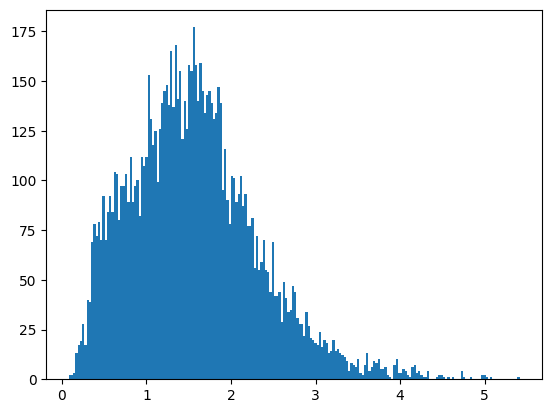

In [1]:
from astroML.datasets import fetch_dr7_quasar
import matplotlib.pyplot as plt
import numpy as np

# Fetch the quasar data
data = fetch_dr7_quasar()

# select the first 10000 points
data = data[:10000]

z = data['redshift']
plt.hist(z, bins=int(len(z)/50))
plt.show()

## Calculating the cdf
Since we don't have an explicit expression for the integral, we cannot compute the CDF directly. Instead, we can approximate it by summing the values in each bin of the histogram cumulatively. This approach allows us to construct a discrete cdf that closely represents the true distribution.

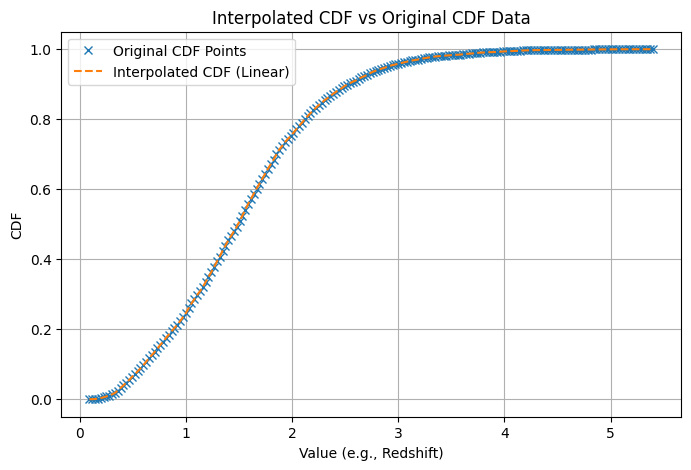

In [2]:
import numpy as np
from scipy.interpolate import interp1d

bin_content, bin_edges = np.histogram(z, bins=int(len(z)/50))
sum = np.sum(bin_content)
bin_content = bin_content / sum
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Compute cdf
cdf_data = np.cumsum(bin_content) 
# Interpolate the cdf
cdf = interp1d(bin_centers, cdf_data, kind='linear', fill_value=(0, 1), bounds_error=False)
# the interp1d function creates a callable object that can be used to evaluate the interpolated CDF at any point 
# within the range of the original data.

plt.figure(figsize=(8, 5))
plt.plot(bin_centers, cdf_data,'x', label='Original CDF Points')
x_vals = np.linspace(min(bin_centers), max(bin_centers), 500)
plt.plot(x_vals, cdf(x_vals), label='Interpolated CDF (Linear)', linestyle='--')
plt.xlabel("Value (e.g., Redshift)")
plt.ylabel("CDF")
plt.title("Interpolated CDF vs Original CDF Data")
plt.legend()
plt.grid(True)
plt.show()

## Calculating the Inverse of the CDF

When working with a discrete cumulative distribution function (cdf) instead of a continuous one, directly inverting the function is not possible. Instead, we must adopt an alternative method to achieve this.

#### Methodology

To generate random samples that follow the original probability distribution:

1. **Generate Uniform Random Numbers**: Create uniformly distributed random values, $\epsilon$, within the range $(0, 1)$, (a cdf is a probability in  mathematical therms and so assume values between 0 and 1).

2. **Solve for the Inverse cdf**: Solve the following equation to find the corresponding data points:
$$
F(x) - \epsilon = 0
$$

#### Root Finding with `brentq`

To efficiently solve the equation above, we use the **Brent’s method** implemented in `scipy.optimize.brentq`. This method is fast, robust, and ideal for solving equations where the function's root lies within a specified interval.

**How Does `brentq` Work?**

The `brentq` algorithm is a combination of:

- **Bisection Method**: Ensures convergence by narrowing the interval where the root exists.
- **Secant Method**: Uses linear interpolation for faster convergence.
- **Inverse Quadratic Interpolation**: Provides even faster convergence when conditions allow.

The algorithm starts by bracketing the root within an interval $[a, b]$ such that $f(a)$ and $f(b)$ have opposite signs (guaranteeing the presence of a root). 


#### Why Does This Work?

By solving for  such that , we are effectively sampling from the inverse of the cdf. Since the inverse cdf maps uniform random values to the original probability distribution, this technique ensures the generated samples follow the desired pdf.


Simulation: 100%|██████████| 1000000/1000000 [13:42<00:00, 1216.00it/s]


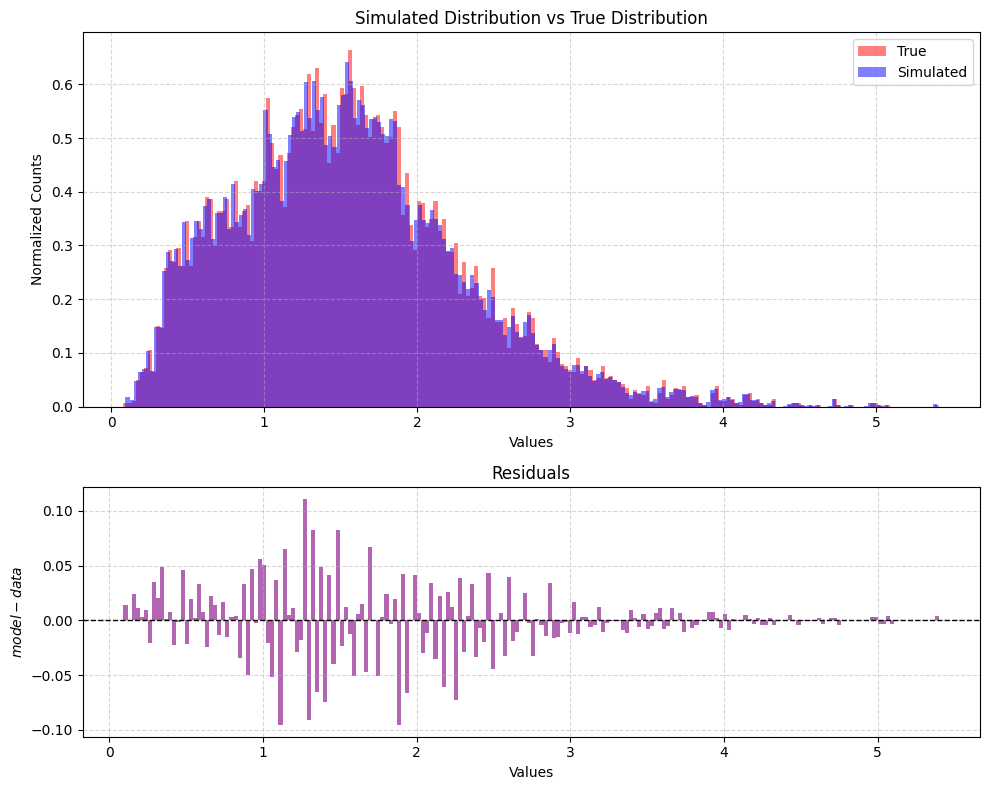

In [3]:
from scipy.optimize import brentq
from tqdm import tqdm
import random

N_samples = 1000000
n_bins = 200

eps = [random.uniform(0, 1) for _ in range(N_samples)]
# It's complitly equivalent to write eps like this:
# eps = np.linspace(0, 1, N_samples)
samples = [brentq(lambda h: cdf(h) - e, 0, max(bin_edges)) for e in tqdm(eps, desc="Simulation")]

fig, ax = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 2]})

ax[0].hist(z, bins=n_bins, alpha=0.5, color='red', density=True, label='True')
hist_simulated, bins_simulated, _ = ax[0].hist(samples, bins=n_bins, alpha=0.5, color='blue', density=True, label='Simulated')
ax[0].set_title("Simulated Distribution vs True Distribution")
ax[0].set_xlabel("Values")
ax[0].set_ylabel("Normalized Counts")
ax[0].legend()
ax[0].grid(True, linestyle='--', alpha=0.5)

bin_centers = 0.5 * (bins_simulated[1:] + bins_simulated[:-1])
hist_true, _ = np.histogram(z, bins=bins_simulated, density=True)

residuals = (hist_simulated - hist_true)

ax[1].bar(bin_centers, residuals, width=np.diff(bins_simulated), color='purple', alpha=0.6, label='Residues')
ax[1].axhline(0, color='black', linestyle='--', linewidth=1)
ax[1].set_title("Residuals")
ax[1].set_xlabel("Values")
ax[1].set_ylabel(r"$model - data$", size=10)
ax[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

#### **Osservation**: Is normalisation necessary?
Of course it is to be able to consider the function $f(x)$ as a pdf.
But we can normalize the results as the last step of the calculus, in the following lines I will use a subscript $N$ to denote the normalized object, and $N$ will be the normalization. 
$$
f_N(x) = Nf(x)
$$
$$
F_N(x) = \int_a^x\,dt\, f_N(t) = \int_a^x\,dt\, Nf(t) = NF(x)
$$
$$
NF(x) = y\,\Rightarrow\, F(x) = \frac{1}{N}y \,\Rightarrow\, F^{-1}_N(x) = F^{-1}\bigg(\frac{1}{N}x\bigg)
$$
The Inverse function algorithm need to compiute random numbers that follow a uniform distribution in $(F(a), F(b))$, that with the normalization become: 
$$
(F_N(a), F_N(b)) = N (F(a), F(b)) \,\Rightarrow\, x_N = Nx
$$
and then we have to evaluate this value with the inverse of the cumulative function:
$$
F^{-1}_N(x_N) = F^{-1}\bigg(\frac{1}{N}Nx\bigg) = F^{-1}(x)
$$
We can see that the normalization does not appear inside the algorithm so it is totally permitted to normalize the simulated sample before plot it.

## Comparison with theoretical distribution

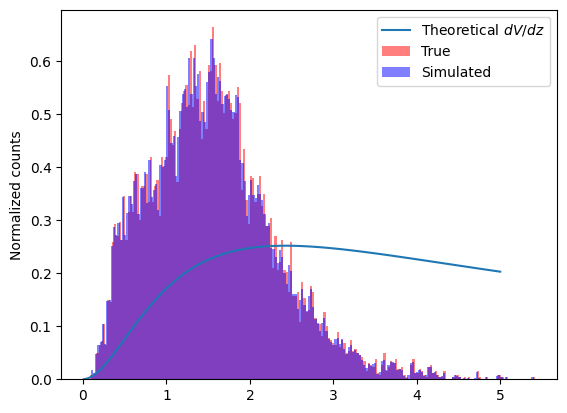

In [6]:
from astropy.cosmology import Planck18
import numpy as np
import matplotlib.pyplot as plt

zgrid = np.linspace(0.01, 5, 100)
dVdz = Planck18.differential_comoving_volume(zgrid).value  # [Mpc^3 / sr]
normalization = np.trapz(dVdz, zgrid)
dVdz /= normalization  # Normalize to make it a PDF

plt.plot(zgrid, dVdz, label='Theoretical $dV/dz$')
plt.hist(z, bins=n_bins, alpha=0.5, color='red', density=True, label='True')
plt.hist(samples, bins=n_bins, alpha=0.5, color='blue', density=True, label='Simulated')
plt.ylabel('Normalized counts')
plt.legend()
plt.show()